Loading raw data from D:\sales_analytics_project\data\raw\sales_with_racks_nepal_electronics.csv...
Data loaded successfully.

--- Starting Exploratory Data Analysis (EDA) ---
Plotting total revenue over time...


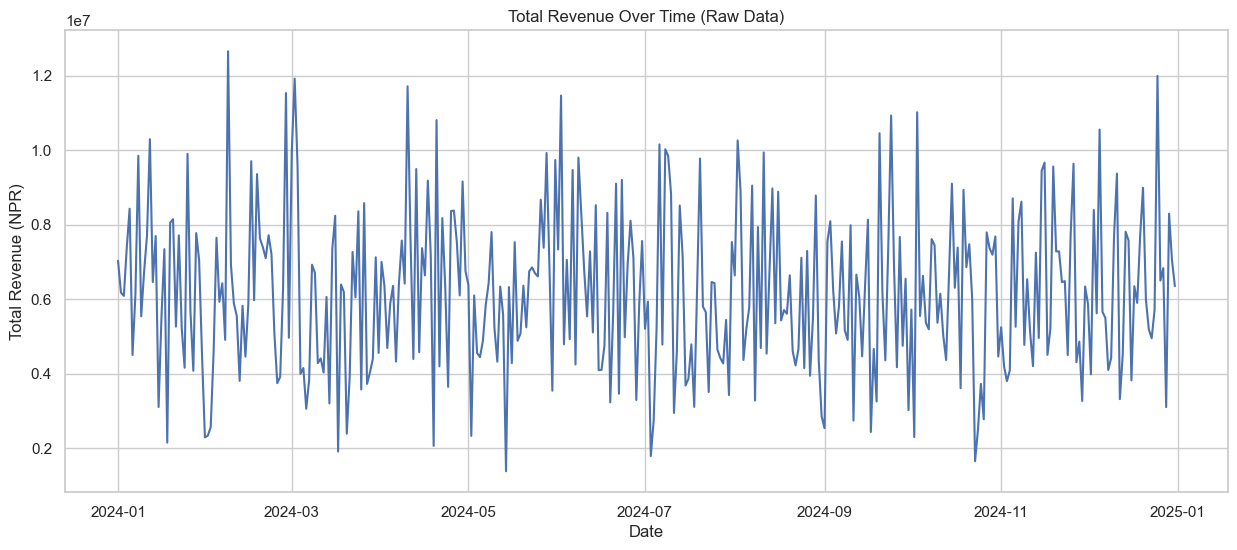

Plotting distributions of key numeric features...


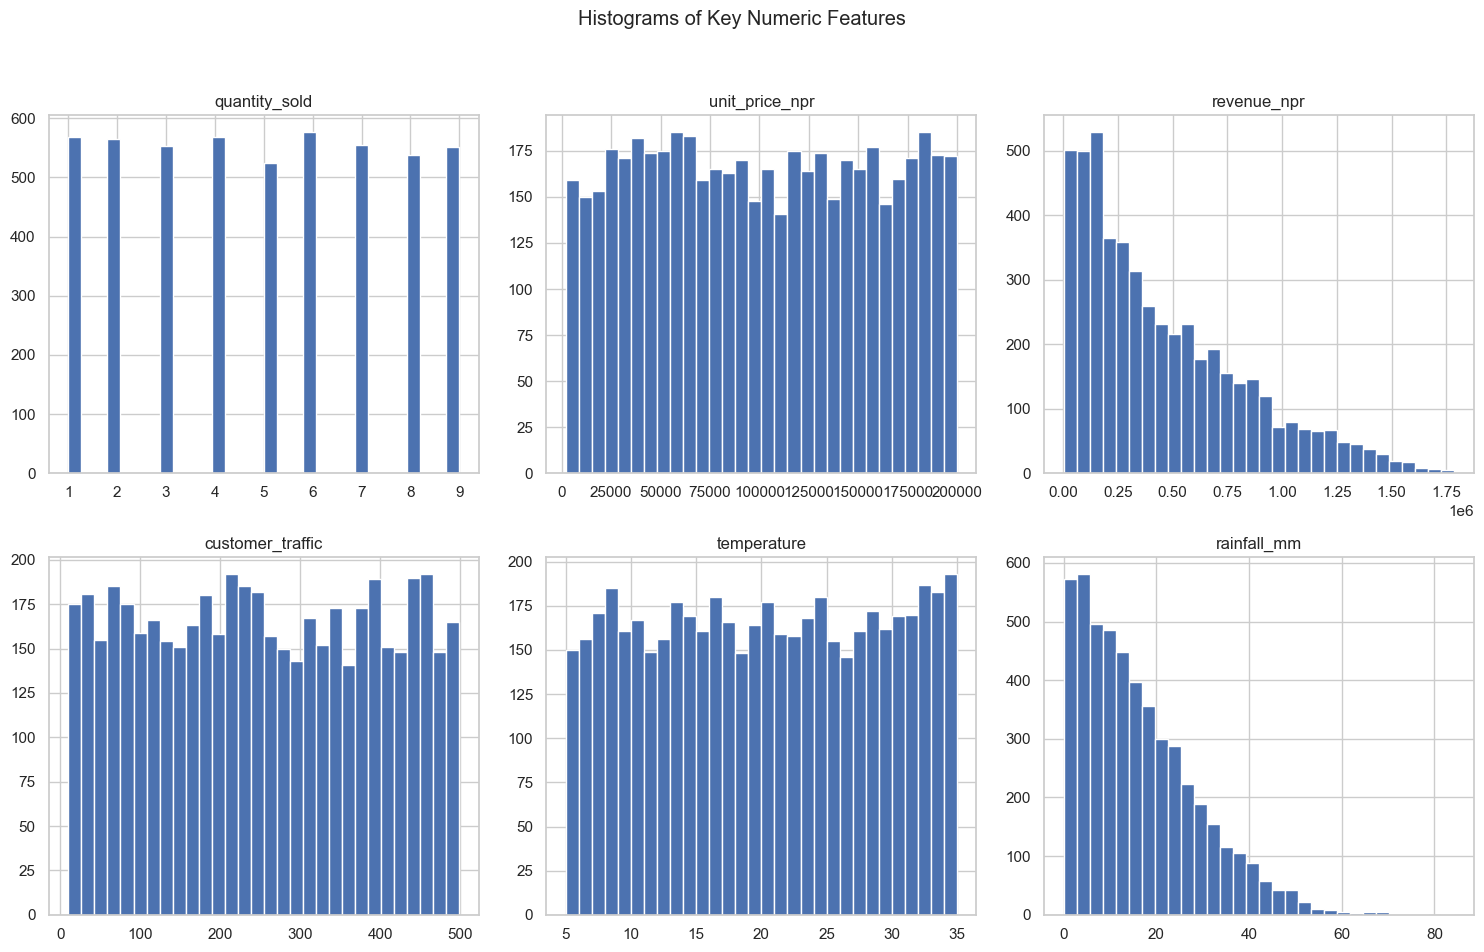

Plotting correlation heatmap...


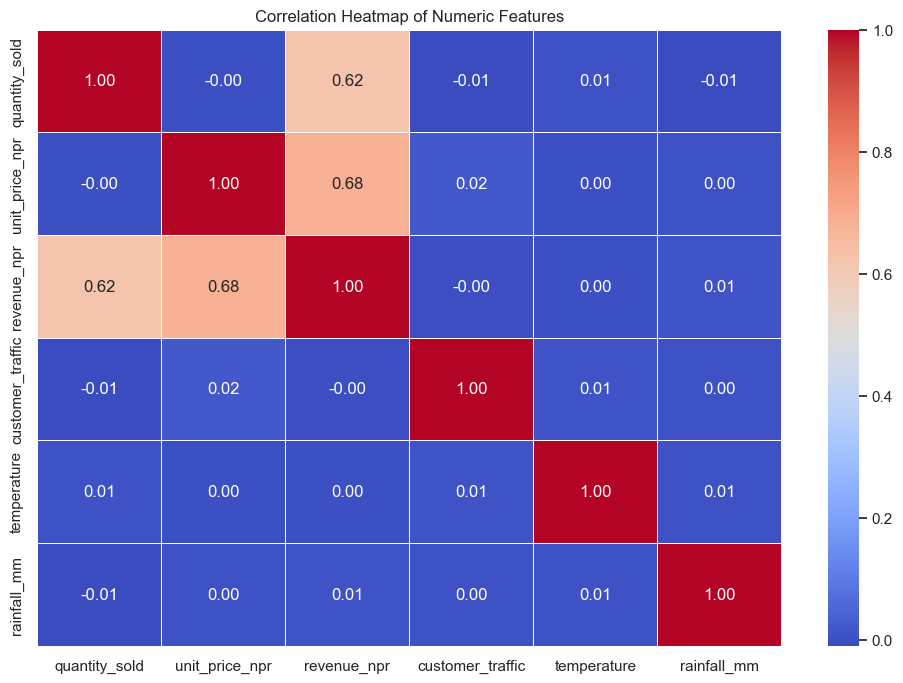


--- Starting Data Cleaning ---
Running basic_cleaning function...
Removed 0 rows with zero/negative quantity.
Cleaning complete.

--- Starting Feature Engineering ---
Adding time features...
Encoding holidays...
Feature engineering complete.

--- Analysis of New Features ---
Plotting revenue by day of week...


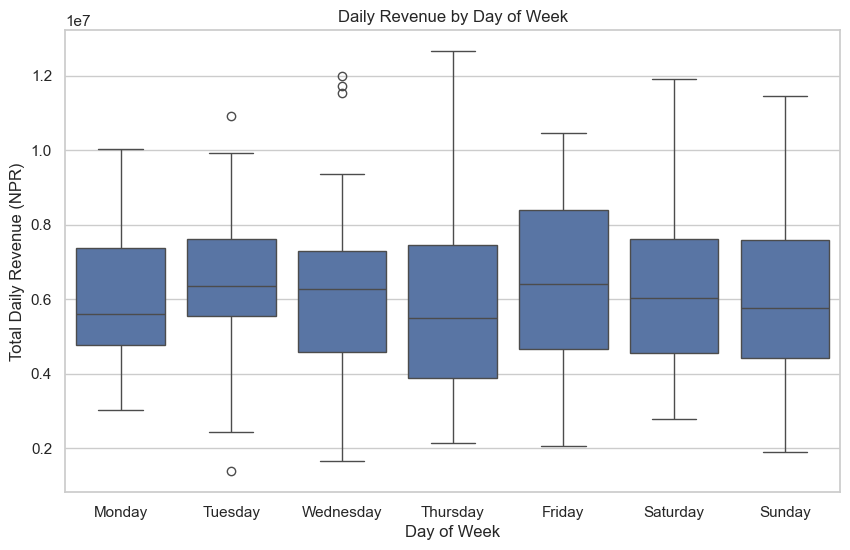

Plotting revenue by festival season...


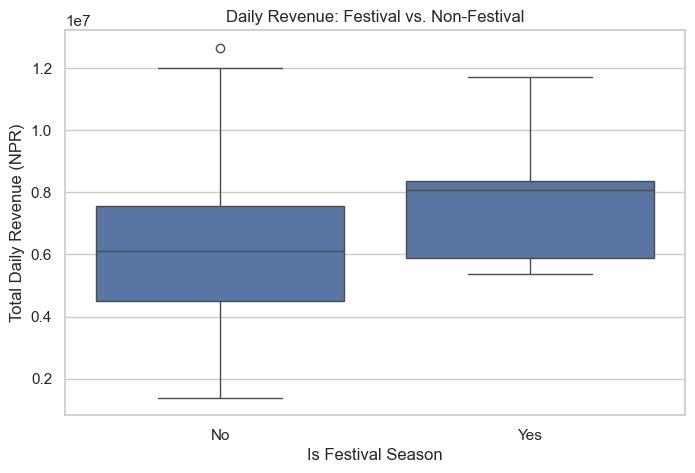


--- Saving Processed Data ---
Featurized data saved to D:\sales_analytics_project\data\processed\featurized_sales_data.csv

--- Analysis Notebook Complete! ---


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# ---------------------------------------------
# Configuration
# ---------------------------------------------
RAW_PATH = Path("D:\\sales_analytics_project\\data\\raw\\sales_with_racks_nepal_electronics.csv")
PROCESSED_PATH = Path("D:\\sales_analytics_project\\data\\processed\\cleaned_sales_data.csv")
FEATURE_PATH = Path("D:\\sales_analytics_project\\data\\processed\\featurized_sales_data.csv")

# Simple Nepali month mapping (approx by Gregorian month)
NEPALI_MONTHS = ["Baisakh","Jestha","Ashadh","Shrawan","Bhadra","Ashwin","Kartik","Mangsir","Poush","Magh","Falgun","Chaitra"]

# ---------------------------------------------
# 1. Load Data
# ---------------------------------------------
print(f"Loading raw data from {RAW_PATH}...")
df_raw = pd.read_csv(RAW_PATH, parse_dates=["date"])
print("Data loaded successfully.")
df_raw.head()

# ---------------------------------------------
# 2. Exploratory Data Analysis (EDA) - THE DIAGRAMS
# ---------------------------------------------
print("\n--- Starting Exploratory Data Analysis (EDA) ---")

# --- Diagram 1: Revenue Over Time ---
print("Plotting total revenue over time...")
plt.figure(figsize=(15, 6))
df_daily_revenue = df_raw.groupby('date')['revenue_npr'].sum().reset_index()
sns.lineplot(data=df_daily_revenue, x='date', y='revenue_npr')
plt.title('Total Revenue Over Time (Raw Data)')
plt.xlabel('Date')
plt.ylabel('Total Revenue (NPR)')
plt.show()

# --- Diagram 2: Distributions of Key Numeric Features ---
print("Plotting distributions of key numeric features...")
numeric_cols = ["quantity_sold", "unit_price_npr", "revenue_npr", "customer_traffic", "temperature", "rainfall_mm"]
df_plot = df_raw[[col for col in numeric_cols if col in df_raw.columns]]

df_plot.hist(bins=30, figsize=(15, 10), layout=(-1, 3))
plt.suptitle('Histograms of Key Numeric Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Diagram 3: Correlation Heatmap ---
print("Plotting correlation heatmap...")
plt.figure(figsize=(12, 8))
corr = df_raw[df_plot.columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# ---------------------------------------------
# 3. Data Cleaning (from data_preprocessing.py)
# ---------------------------------------------
print("\n--- Starting Data Cleaning ---")

def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    print("Running basic_cleaning function...")
    df_clean = df.copy()
    # 1. Standardize column names
    df_clean.columns = [c.strip() for c in df_clean.columns]
    
    # 2. Ensure date is datetime
    df_clean["date"] = pd.to_datetime(df_clean["date"])
    
    # 3. Remove exact duplicates
    df_clean = df_clean.drop_duplicates()

    # 4. Fix negative or impossible values
    numeric_cols = ["quantity_sold","unit_price_npr","discount_percent",
                    "revenue_npr","cost_npr","profit_npr","customer_traffic",
                    "inventory_level","rainfall_mm","temperature","petrol_price"]
    for c in numeric_cols:
        if c in df_clean.columns:
            df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

    # 5. Fill or drop missing for critical columns
    df_clean = df_clean.dropna(subset=["date","product_id","store_id","quantity_sold","unit_price_npr"])

    # 6. Fill numeric NaNs with sensible defaults (median)
    for c in numeric_cols:
        if c in df_clean.columns and df_clean[c].isnull().any():
            median = df_clean[c].median()
            df_clean[c] = df_clean[c].fillna(median)
            print(f"Filled NaNs in '{c}' with median value ({median})")

    # 7. Remove rows with zero or negative quantity
    initial_rows = len(df_clean)
    df_clean = df_clean[df_clean["quantity_sold"] > 0]
    print(f"Removed {initial_rows - len(df_clean)} rows with zero/negative quantity.")
    
    print("Cleaning complete.")
    return df_clean

df_cleaned = basic_cleaning(df_raw)

# ---------------------------------------------
# 4. Feature Engineering (from feature_engineering.py)
# ---------------------------------------------
print("\n--- Starting Feature Engineering ---")

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    print("Adding time features...")
    df["day_of_week"] = df["date"].dt.day_name()
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["weekofyear"] = df["date"].dt.isocalendar().week
    df["nepali_month"] = df["date"].dt.month.apply(lambda m: NEPALI_MONTHS[(m-1)%12])
    df["is_salary_week"] = df["date"].dt.day.between(1,7).astype(int)
    return df

def encode_holidays(df: pd.DataFrame) -> pd.DataFrame:
    print("Encoding holidays...")
    festival_cols = ["is_dashain","is_tihar","is_holi","is_eid","is_lhosar","is_holiday","holiday_name"]
    for c in festival_cols:
        if c not in df.columns:
            df[c] = False if c!="holiday_name" else ""
    df["festival_season"] = df[["is_dashain","is_tihar","is_holi","is_eid","is_lhosar"]].any(axis=1).astype(int)
    return df

df_featured = add_time_features(df_cleaned)
df_featured = encode_holidays(df_featured)

print("Feature engineering complete.")
df_featured.head()

# ---------------------------------------------
# 5. Post-Engineering Analysis (More Diagrams)
# ---------------------------------------------
print("\n--- Analysis of New Features ---")

# --- Diagram 4: Revenue by Day of Week ---
print("Plotting revenue by day of week...")
plt.figure(figsize=(10, 6))
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=df_featured.groupby(['date', 'day_of_week'])['revenue_npr'].sum().reset_index(), 
            x='day_of_week', y='revenue_npr', order=day_order)
plt.title('Daily Revenue by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Daily Revenue (NPR)')
plt.show()

# --- Diagram 5: Revenue by Festival Season ---
print("Plotting revenue by festival season...")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_featured.groupby(['date', 'festival_season'])['revenue_npr'].sum().reset_index(), 
            x='festival_season', y='revenue_npr')
plt.title('Daily Revenue: Festival vs. Non-Festival')
plt.xlabel('Is Festival Season')
plt.ylabel('Total Daily Revenue (NPR)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# ---------------------------------------------
# 6. Save Processed Data
# ---------------------------------------------
print("\n--- Saving Processed Data ---")
FEATURE_PATH.parent.mkdir(parents=True, exist_ok=True)
df_featured.to_csv(FEATURE_PATH, index=False)
print(f"Featurized data saved to {FEATURE_PATH}")

print("\n--- Analysis Notebook Complete! ---")